# Dog Length-of-Stay (LOS) Prediction Pipeline
## Dallas Animal Shelter Data Analysis - MLP Regression & Classification

This notebook contains:
- **MLP Regression Model**: Predicts exact length of stay in days
- **MLP Classification Models**: Binary classification for K=7, 14, 28 days thresholds
  - Predicts whether a dog will stay longer than K days (1) or not (0)

Features enhanced feature engineering and improved MLP architecture with better training strategies.



## 1. Environment Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import re
import random
from typing import Dict, List
warnings.filterwarnings('ignore')

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, f1_score, precision_score, recall_score,
    brier_score_loss
)
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import RobustScaler, StandardScaler

# Hyperparameter tuning
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available. Install with: pip install optuna")

# Set random seeds for reproducibility
SEED = 42
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(RANDOM_SEED)

# Create output directories
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Random seed set to: {RANDOM_SEED}")


Environment setup complete!
PyTorch version: 2.5.1+cu121
Random seed set to: 42


## 2. Data Loading & Extensive Feature Engineering


In [2]:
# Extensive feature engineering for maximum model performance
FILE_PATH = 'Dallas_Animal_Shelter_Data_Fiscal_Year_2023_-_2026_20251115.csv'

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def cyclical_encode(series, max_val):
    """Encode cyclical features (month, day, etc.) using sin/cos"""
    sin_val = np.sin(2 * np.pi * series / max_val)
    cos_val = np.cos(2 * np.pi * series / max_val)
    return sin_val, cos_val

def extract_text_features(text_col, keywords_list):
    """Extract binary features from text columns based on keywords"""
    if text_col is None or pd.isna(text_col):
        return [0] * len(keywords_list)
    text_upper = str(text_col).upper()
    return [1 if keyword in text_upper else 0 for keyword in keywords_list]

def load_dallas_data_for_mlp_regression(device=None):
    """Load and preprocess data with EXTENSIVE feature engineering"""
    if device is None:
        device = get_device()
    
    if not os.path.isfile(FILE_PATH):
        raise FileNotFoundError(f"Data file not found at {FILE_PATH}")
    
    df = pd.read_csv(FILE_PATH, low_memory=False)
    print(f"Loaded {len(df)} records. Filtering dogs...")
    df = df[df["Animal_Type"] == "DOG"].copy()
    print(f"After Animal_Type == DOG: {len(df)} records")
    
    # Parse dates and calculate StayLength
    df["Intake_Date"] = pd.to_datetime(df["Intake_Date"], errors="coerce")
    df["Outcome_Date"] = pd.to_datetime(df["Outcome_Date"], errors="coerce")
    df["StayLength"] = (df["Outcome_Date"] - df["Intake_Date"]).dt.days
    df = df[df["StayLength"].notna() & (df["StayLength"] >= 0)].reset_index(drop=True)
    
    print(f"StayLength stats: mean={df['StayLength'].mean():.2f}, std={df['StayLength'].std():.2f}")
    print("\n" + "="*60)
    print("FEATURE ENGINEERING")
    print("="*60)
    
    # ========== 1. TEMPORAL FEATURES ==========
    
    # Basic temporal
    df["Intake_Month"] = df["Intake_Date"].dt.month
    df["Intake_Weekday"] = df["Intake_Date"].dt.weekday
    df["Intake_Day"] = df["Intake_Date"].dt.day
    df["Intake_Quarter"] = df["Intake_Date"].dt.quarter
    df["Intake_WeekOfYear"] = df["Intake_Date"].dt.isocalendar().week
    df["Intake_DayOfYear"] = df["Intake_Date"].dt.dayofyear
    df["Intake_Year"] = df["Intake_Date"].dt.year
    
    # Cyclical encoding for temporal features (captures periodic patterns)
    df["Month_Sin"], df["Month_Cos"] = cyclical_encode(df["Intake_Month"], 12)
    df["Weekday_Sin"], df["Weekday_Cos"] = cyclical_encode(df["Intake_Weekday"], 7)
    df["Day_Sin"], df["Day_Cos"] = cyclical_encode(df["Intake_Day"], 31)
    df["WeekOfYear_Sin"], df["WeekOfYear_Cos"] = cyclical_encode(df["Intake_WeekOfYear"], 52)
    
    # Season (based on month)
    df["Season"] = df["Intake_Month"].apply(
        lambda m: "Spring" if m in [3,4,5] else "Summer" if m in [6,7,8] 
        else "Fall" if m in [9,10,11] else "Winter"
    )
    
    # Binary temporal flags
    df["IsWeekend"] = (df["Intake_Weekday"] >= 5).astype(int)
    df["IsMonthStart"] = (df["Intake_Date"].dt.day <= 7).astype(int)
    df["IsMonthEnd"] = (df["Intake_Date"].dt.day >= 25).astype(int)
    df["IsQuarterStart"] = df["Intake_Month"].isin([1, 4, 7, 10]).astype(int)
    df["IsQuarterEnd"] = df["Intake_Month"].isin([3, 6, 9, 12]).astype(int)
    
    # Day of week categories
    df["DayType"] = df["Intake_Weekday"].apply(
        lambda x: "Weekend" if x >= 5 else "Weekday"
    )
    
    # ========== 2. AGE FEATURES ==========
    if "Age_Group_at_Intake" in df.columns:
        def get_age_group(age_str):
            if pd.isna(age_str):
                return "unknown"
            age_upper = str(age_str).upper()
            if "PUPPY" in age_upper or "YOUNG" in age_upper:
                return "puppy"
            elif "SENIOR" in age_upper or "GERIATRIC" in age_upper:
                return "senior"
            else:
                return "adult"
        df["Age_Group"] = df["Age_Group_at_Intake"].apply(get_age_group)
    else:
        df["Age_Group"] = "unknown"
    
    # ========== 3. CONDITION FEATURES ==========
    def simplify_condition(cond):
        if pd.isna(cond):
            return "unknown"
        cond_upper = str(cond).upper()
        if "HEALTHY" in cond_upper or "NORMAL" in cond_upper or "APP" in cond_upper:
            return "healthy"
        elif "INJUR" in cond_upper:
            return "injured"
        elif "SICK" in cond_upper:
            return "sick"
        elif "CRITICAL" in cond_upper:
            return "critical"
        else:
            return "other"
    
    df["Intake_Condition_Simple"] = df["Intake_Condition"].apply(simplify_condition)
    
    # Binary condition flags
    if "Intake_Condition" in df.columns:
        df["Is_Healthy"] = df["Intake_Condition"].str.contains("HEALTHY|NORMAL|APP", case=False, na=False).astype(int)
        df["Is_Injured"] = df["Intake_Condition"].str.contains("INJUR", case=False, na=False).astype(int)
        df["Is_Sick"] = df["Intake_Condition"].str.contains("SICK", case=False, na=False).astype(int)
        df["Is_Critical"] = df["Intake_Condition"].str.contains("CRITICAL", case=False, na=False).astype(int)
    else:
        df["Is_Healthy"] = 0
        df["Is_Injured"] = 0
        df["Is_Sick"] = 0
        df["Is_Critical"] = 0
    
    # ========== 4. BREED FEATURES ==========
    breed_counts = df["Animal_Breed"].value_counts()
    top_breeds = breed_counts.head(20).index.tolist()  # Increased to top 20
    df["Breed_Simple"] = df["Animal_Breed"].apply(
        lambda x: x if x in top_breeds else "OTHER"
    )
    
    # Frequency encoding
    breed_freq = df["Animal_Breed"].value_counts().to_dict()
    df["Breed_Frequency"] = df["Animal_Breed"].map(breed_freq).fillna(0)
    
    # Breed size estimation (if breed name contains size indicators)
    def estimate_breed_size(breed_str):
        if pd.isna(breed_str):
            return "unknown"
        breed_upper = str(breed_str).upper()
        if any(word in breed_upper for word in ["GIANT", "GREAT DANE", "MASTIFF", "ST BERNARD", "NEWFOUNDLAND"]):
            return "giant"
        elif any(word in breed_upper for word in ["LARGE", "SHEPHERD", "RETRIEVER", "LABRADOR", "ROTTWEILER"]):
            return "large"
        elif any(word in breed_upper for word in ["MEDIUM", "BEAGLE", "BULLDOG", "TERRIER"]):
            return "medium"
        elif any(word in breed_upper for word in ["SMALL", "CHIHUAHUA", "POMERANIAN", "TOY", "MINIATURE"]):
            return "small"
        else:
            return "unknown"
    
    df["Breed_Size"] = df["Animal_Breed"].apply(estimate_breed_size)
    
    # ========== 5. INTAKE TYPE FEATURES ==========
    df["Intake_Type"] = df["Intake_Type"].fillna("UNKNOWN")
    
    # Binary intake type flags
    df["Is_Stray"] = df["Intake_Type"].str.contains("STRAY", case=False, na=False).astype(int)
    df["Is_Owner_Surrender"] = df["Intake_Type"].str.contains("OWNER|SURRENDER", case=False, na=False).astype(int)
    df["Is_Public_Assist"] = df["Intake_Type"].str.contains("PUBLIC|ASSIST", case=False, na=False).astype(int)
    df["Is_Confiscated"] = df["Intake_Type"].str.contains("CONFISCAT", case=False, na=False).astype(int)
    
    # Intake subtype features (if available)
    if "Intake_Subtype" in df.columns:
        df["Intake_Subtype"] = df["Intake_Subtype"].fillna("UNKNOWN")
        subtype_freq = df["Intake_Subtype"].value_counts().to_dict()
        df["Subtype_Frequency"] = df["Intake_Subtype"].map(subtype_freq).fillna(0)
    else:
        df["Intake_Subtype"] = "UNKNOWN"
        df["Subtype_Frequency"] = 0
    
    # ========== 6. CHIP FEATURES ==========
    if "Chip_Status" in df.columns:
        df["Has_Chip"] = df["Chip_Status"].str.contains("CHIP", case=False, na=False).astype(int)
        df["Chip_Status_Simple"] = df["Chip_Status"].apply(
            lambda x: "chipped" if pd.notna(x) and "CHIP" in str(x).upper() else "not_chipped"
        )
    else:
        df["Has_Chip"] = 0
        df["Chip_Status_Simple"] = "unknown"
    
    # ========== 7. OUTCOME FEATURES ==========
    if "Outcome_Type" in df.columns:
        df["Outcome_Type"] = df["Outcome_Type"].fillna("UNKNOWN")
        df["Is_Adoption"] = df["Outcome_Type"].str.contains("ADOPTION", case=False, na=False).astype(int)
        df["Is_Transfer"] = df["Outcome_Type"].str.contains("TRANSFER", case=False, na=False).astype(int)
        df["Is_Return_to_Owner"] = df["Outcome_Type"].str.contains("RETURN|OWNER", case=False, na=False).astype(int)
    else:
        df["Outcome_Type"] = "UNKNOWN"
        df["Is_Adoption"] = 0
        df["Is_Transfer"] = 0
        df["Is_Return_to_Owner"] = 0
    
    # ========== 8. LOCATION FEATURES ==========
    if "Council_District" in df.columns:
        df["Council_District"] = df["Council_District"].fillna("UNKNOWN")
        district_freq = df["Council_District"].value_counts().to_dict()
        df["District_Frequency"] = df["Council_District"].map(district_freq).fillna(0)
    else:
        df["Council_District"] = "UNKNOWN"
        df["District_Frequency"] = 0
    
    if "Animal_Origin" in df.columns:
        df["Animal_Origin"] = df["Animal_Origin"].fillna("UNKNOWN")
        origin_freq = df["Animal_Origin"].value_counts().to_dict()
        df["Origin_Frequency"] = df["Animal_Origin"].map(origin_freq).fillna(0)
    else:
        df["Animal_Origin"] = "UNKNOWN"
        df["Origin_Frequency"] = 0
    
    # ========== 9. TEXT FEATURES ==========
    # Reason features
    if "Reason" in df.columns:
        reason_keywords = ["AGGRESSIVE", "BEHAVIOR", "MEDICAL", "TIME", "MONEY", "MOVING", "ALLERGY"]
        for i, keyword in enumerate(reason_keywords):
            df[f"Reason_{keyword}"] = df["Reason"].str.contains(keyword, case=False, na=False).astype(int)
    else:
        reason_keywords = []
        for keyword in ["AGGRESSIVE", "BEHAVIOR", "MEDICAL", "TIME", "MONEY", "MOVING", "ALLERGY"]:
            df[f"Reason_{keyword}"] = 0
    
    # Hold request features
    if "Hold_Request" in df.columns:
        df["Has_Hold_Request"] = df["Hold_Request"].notna().astype(int)
        df["Hold_Request_Length"] = df["Hold_Request"].astype(str).str.len()
    else:
        df["Has_Hold_Request"] = 0
        df["Hold_Request_Length"] = 0
    
    # ========== 10. FREQUENCY ENCODING ==========
    high_cardinality_features = ["Intake_Type", "Intake_Subtype", "Animal_Breed", 
                                 "Council_District", "Animal_Origin", "Outcome_Type"]
    for feat in high_cardinality_features:
        if feat in df.columns:
            df[f"{feat}_Frequency"] = df[feat].map(df[feat].value_counts()).fillna(0)
    
    # ========== 11. POLYNOMIAL FEATURES ==========
    df["Breed_Frequency_Squared"] = df["Breed_Frequency"] ** 2
    df["Breed_Frequency_Sqrt"] = np.sqrt(df["Breed_Frequency"] + 1)
    if "Subtype_Frequency" in df.columns:
        df["Subtype_Frequency_Squared"] = df["Subtype_Frequency"] ** 2
    
    # Target variable
    y_all = df["StayLength"].to_numpy().astype(float)
    
    # ========== SPLIT DATA FIRST (for target encoding) ==========
    idx_all = np.arange(len(df))
    idx_trainval, idx_test = train_test_split(idx_all, test_size=0.15, random_state=SEED)
    idx_train, idx_val = train_test_split(idx_trainval, test_size=(0.15/(1.0-0.15)), random_state=SEED)
    
    df_train = df.iloc[idx_train].reset_index(drop=True)
    df_val = df.iloc[idx_val].reset_index(drop=True)
    df_test = df.iloc[idx_test].reset_index(drop=True)
    
    y_train = y_all[idx_train]
    y_val = y_all[idx_val]
    y_test = y_all[idx_test]
    
    # ========== 12. TARGET ENCODING ==========
    target_encode_features = ["Intake_Type", "Intake_Subtype", "Animal_Breed", 
                              "Council_District", "Breed_Simple", "Season"]
    
    for feat in target_encode_features:
        if feat in df_train.columns:
            stats = df_train.groupby(feat)["StayLength"].agg(['mean', 'std', 'count']).fillna(0)
            for stat in ['mean', 'std', 'count']:
                mapping = stats[stat].to_dict()
                default = y_train.mean() if stat == 'mean' else 0
                for split in [df_train, df_val, df_test]:
                    split[f"{feat}_Target{stat.capitalize()}"] = split[feat].map(mapping).fillna(default)
    
    # ========== SELECT FEATURES ==========
    
    # Numeric features
    numeric_features = [
        # Temporal
        "Intake_Month", "Intake_Weekday", "Intake_Day", "Intake_Quarter", 
        "Intake_WeekOfYear", "Intake_DayOfYear", "Intake_Year",
        # Cyclical
        "Month_Sin", "Month_Cos", "Weekday_Sin", "Weekday_Cos",
        "Day_Sin", "Day_Cos", "WeekOfYear_Sin", "WeekOfYear_Cos",
        # Binary temporal
        "IsWeekend", "IsMonthStart", "IsMonthEnd", "IsQuarterStart", "IsQuarterEnd",
        # Condition flags
        "Is_Healthy", "Is_Injured", "Is_Sick", "Is_Critical",
        # Intake type flags
        "Is_Stray", "Is_Owner_Surrender", "Is_Public_Assist", "Is_Confiscated",
        # Chip
        "Has_Chip",
        # Outcome flags
        "Is_Adoption", "Is_Transfer", "Is_Return_to_Owner",
        # Frequency encodings
        "Breed_Frequency", "Subtype_Frequency", "District_Frequency", 
        "Origin_Frequency", "Intake_Type_Frequency", "Intake_Subtype_Frequency",
        "Outcome_Type_Frequency",
        # Polynomial
        "Breed_Frequency_Squared", "Breed_Frequency_Sqrt",
        # Text features
        "Has_Hold_Request", "Hold_Request_Length",
    ]
    
    # Add reason keyword features
    numeric_features.extend([f"Reason_{kw}" for kw in reason_keywords if f"Reason_{kw}" in df_train.columns])
    
    # Add target encoding features
    for feat in target_encode_features:
        if feat in df_train.columns:
            numeric_features.extend([f"{feat}_TargetMean", f"{feat}_TargetStd", f"{feat}_TargetCount"])
    
    # Categorical features (for one-hot encoding)
    categorical_features = [
        "Intake_Type", "Intake_Condition_Simple", "Breed_Simple", "Age_Group",
        "Season", "DayType", "Breed_Size", "Chip_Status_Simple"
    ]
    
    # Add optional categorical features if they exist
    optional_categorical = ["Intake_Subtype", "Council_District", "Animal_Origin", "Outcome_Type"]
    for feat in optional_categorical:
        if feat in df_train.columns:
            categorical_features.append(feat)
    
    # Filter to existing features
    numeric_features = [f for f in numeric_features if f in df_train.columns]
    categorical_features = [f for f in categorical_features if f in df_train.columns]
    
    # ========== FEATURE SELECTION & PREPROCESSING ==========
    X_num_train_raw = df_train[numeric_features].fillna(0.0).values.astype(np.float32)
    X_num_val_raw = df_val[numeric_features].fillna(0.0).values.astype(np.float32)
    X_num_test_raw = df_test[numeric_features].fillna(0.0).values.astype(np.float32)
    
    # Feature selection using mutual information
    n_features = min(50, len(numeric_features))
    selector = SelectKBest(mutual_info_regression, k=n_features)
    X_num_train = selector.fit_transform(X_num_train_raw, y_train)
    X_num_val = selector.transform(X_num_val_raw)
    X_num_test = selector.transform(X_num_test_raw)
    numeric_features = [numeric_features[i] for i in selector.get_support(indices=True)]
    
    # Robust scaling
    scaler = RobustScaler()
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = scaler.transform(X_num_val)
    X_num_test = scaler.transform(X_num_test)
    
    # One-hot encode categorical features (fit on train only)
    cat_train = pd.get_dummies(df_train[categorical_features].fillna("unknown"), 
                               prefix=categorical_features, dummy_na=False)
    cat_val = pd.get_dummies(df_val[categorical_features].fillna("unknown"), 
                            prefix=categorical_features, dummy_na=False)
    cat_test = pd.get_dummies(df_test[categorical_features].fillna("unknown"), 
                             prefix=categorical_features, dummy_na=False)
    
    # Align columns (ensure val/test have same columns as train)
    cat_val = cat_val.reindex(columns=cat_train.columns, fill_value=0)
    cat_test = cat_test.reindex(columns=cat_train.columns, fill_value=0)
    
    X_cat_train = cat_train.to_numpy().astype(np.float32)
    X_cat_val = cat_val.to_numpy().astype(np.float32)
    X_cat_test = cat_test.to_numpy().astype(np.float32)
    
    # ========== 13. STATISTICAL & CLUSTERING FEATURES ==========
    # Percentile features
    for col in ["Intake_Month", "Intake_Weekday", "Breed_Frequency"][:3]:
        if col in df_train.columns:
            for split in [df_train, df_val, df_test]:
                split[f"{col}_percentile"] = split[col].rank(pct=True)
    
    # Group-based statistics
    if "Breed_Frequency" in df_train.columns:
        breed_stats = df_train.groupby("Breed_Simple")["Breed_Frequency"].mean()
        for split in [df_train, df_val, df_test]:
            split["Breed_Frequency_breed_mean"] = split["Breed_Simple"].map(breed_stats).fillna(0)
    
    # Clustering features
    cluster_features = [c for c in ["Intake_Month", "Intake_Weekday", "Breed_Frequency", 
                                    "Has_Chip", "Is_Stray"] if c in df_train.columns]
    if len(cluster_features) >= 3:
        cluster_data = [df_train[cluster_features].fillna(0).values,
                       df_val[cluster_features].fillna(0).values,
                       df_test[cluster_features].fillna(0).values]
        cluster_scaled = [StandardScaler().fit_transform(cluster_data[0]),
                         StandardScaler().fit(cluster_data[0]).transform(cluster_data[1]),
                         StandardScaler().fit(cluster_data[0]).transform(cluster_data[2])]
        
        for n_clusters in [3, 5]:
            kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
            clusters = kmeans.fit_predict(cluster_scaled[0])
            centers = kmeans.cluster_centers_
            
            for i, split in enumerate([df_train, df_val, df_test]):
                split[f"Cluster_{n_clusters}"] = kmeans.predict(cluster_scaled[i]) if i > 0 else clusters
                split[f"Cluster_{n_clusters}_dist"] = np.min(
                    np.linalg.norm(cluster_scaled[i][:, None] - centers, axis=2), axis=1
                )
    
    # ========== 14. RATIOS & TRANSFORMS ==========
    if "Breed_Frequency" in df_train.columns and "Subtype_Frequency" in df_train.columns:
        for split in [df_train, df_val, df_test]:
            split["Breed_Subtype_Ratio"] = (split["Breed_Frequency"] + 1) / (split["Subtype_Frequency"] + 1)
    
    for col in ["Intake_Month", "Breed_Frequency"][:2]:
        if col in df_train.columns:
            for split in [df_train, df_val, df_test]:
                split[f"{col}_log"] = np.log1p(split[col].clip(lower=0))
    
    # ========== 15. LEAVE-ONE-OUT ENCODING ==========
    loo_features = ["Intake_Type", "Breed_Simple", "Season"]
    for feat in loo_features:
        if feat in df_train.columns:
            loo_means = [df_train.loc[(np.arange(len(df_train)) != i) & 
                                     (df_train[feat] == df_train.iloc[i][feat]), 
                                     "StayLength"].mean() or y_train.mean() 
                        for i in range(len(df_train))]
            df_train[f"{feat}_LOO_Mean"] = loo_means
            train_means = df_train.groupby(feat)["StayLength"].mean().to_dict()
            df_val[f"{feat}_LOO_Mean"] = df_val[feat].map(train_means).fillna(y_train.mean())
            df_test[f"{feat}_LOO_Mean"] = df_test[feat].map(train_means).fillna(y_train.mean())
    
    # ========== 16. INTERACTION FEATURES ==========
    
    # Create interaction features by multiplying relevant one-hot encoded features
    interaction_cols = []
    
    # Intake_Type × Intake_Condition interaction
    if "Intake_Type" in categorical_features and "Intake_Condition_Simple" in categorical_features:
        intake_type_cols = [c for c in cat_train.columns if c.startswith("Intake_Type_")]
        condition_cols = [c for c in cat_train.columns if c.startswith("Intake_Condition_Simple_")]
        # Take top interactions (to avoid explosion)
        for it_col in intake_type_cols[:5]:  # Limit to top 5
            for cond_col in condition_cols[:3]:  # Limit to top 3
                interaction_cols.append(f"{it_col}_x_{cond_col}")
                cat_train[f"{it_col}_x_{cond_col}"] = (cat_train[it_col] * cat_train[cond_col]).astype(np.float32)
                cat_val[f"{it_col}_x_{cond_col}"] = (cat_val[it_col] * cat_val[cond_col]).astype(np.float32)
                cat_test[f"{it_col}_x_{cond_col}"] = (cat_test[it_col] * cat_test[cond_col]).astype(np.float32)
    
    # Breed × Age interaction
    if "Breed_Simple" in categorical_features and "Age_Group" in categorical_features:
        breed_cols = [c for c in cat_train.columns if c.startswith("Breed_Simple_")]
        age_cols = [c for c in cat_train.columns if c.startswith("Age_Group_")]
        for breed_col in breed_cols[:5]:
            for age_col in age_cols[:3]:
                interaction_cols.append(f"{breed_col}_x_{age_col}")
                cat_train[f"{breed_col}_x_{age_col}"] = (cat_train[breed_col] * cat_train[age_col]).astype(np.float32)
                cat_val[f"{breed_col}_x_{age_col}"] = (cat_val[breed_col] * cat_val[age_col]).astype(np.float32)
                cat_test[f"{breed_col}_x_{age_col}"] = (cat_test[breed_col] * cat_test[age_col]).astype(np.float32)
    
    # Re-align after adding interactions
    cat_val = cat_val.reindex(columns=cat_train.columns, fill_value=0)
    cat_test = cat_test.reindex(columns=cat_train.columns, fill_value=0)
    
    X_cat_train = cat_train.to_numpy().astype(np.float32)
    X_cat_val = cat_val.to_numpy().astype(np.float32)
    X_cat_test = cat_test.to_numpy().astype(np.float32)
    
    if len(interaction_cols) > 0:
        print(f"Created {len(interaction_cols)} interaction features")
    
    # ========== 17. UPDATE FEATURE LISTS ==========
    # Add new numeric features
    new_numeric = []
    for col in ["Intake_Month", "Intake_Weekday", "Breed_Frequency"]:
        if f"{col}_percentile" in df_train.columns:
            new_numeric.append(f"{col}_percentile")
    new_numeric.extend([f"Cluster_{n}_dist" for n in [3, 5] if f"Cluster_{n}_dist" in df_train.columns])
    new_numeric.extend([f"{feat}_LOO_Mean" for feat in loo_features if f"{feat}_LOO_Mean" in df_train.columns])
    if "Breed_Subtype_Ratio" in df_train.columns:
        new_numeric.append("Breed_Subtype_Ratio")
    if "Breed_Frequency_breed_mean" in df_train.columns:
        new_numeric.append("Breed_Frequency_breed_mean")
    new_numeric.extend([f"{col}_log" for col in ["Intake_Month", "Breed_Frequency"] if f"{col}_log" in df_train.columns])
    
    numeric_features.extend(new_numeric)
    numeric_features = [f for f in numeric_features if f in df_train.columns]
    
    # Add cluster labels to categorical
    for n in [3, 5]:
        if f"Cluster_{n}" in df_train.columns:
            for split in [df_train, df_val, df_test]:
                split[f"Cluster_{n}"] = split[f"Cluster_{n}"].astype(str)
            categorical_features.append(f"Cluster_{n}")
    
    # Concatenate features
    X_train = np.concatenate([X_num_train, X_cat_train], axis=1)
    X_val = np.concatenate([X_num_val, X_cat_val], axis=1)
    X_test = np.concatenate([X_num_test, X_cat_test], axis=1)
    
    feature_names = numeric_features + list(cat_train.columns)
    
    meta = {
        "numeric_features": numeric_features,
        "categorical_features": categorical_features,
        "feature_names": feature_names,
        "input_dim": X_train.shape[1],
        "train_size": X_train.shape[0],
        "val_size": X_val.shape[0],
        "test_size": X_test.shape[0],
        "scaler": scaler,
    }
    
    print(f"\n[DATA] train={meta['train_size']}, val={meta['val_size']}, test={meta['test_size']}, "
          f"features={meta['input_dim']} ({len(numeric_features)} numeric, {len(categorical_features)} categorical)")
    print("="*60)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, meta

print("Feature engineering function defined!")


Feature engineering function defined!


## 4. MLP Model Definition

In [3]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[256, 128, 64], dropout=0.4, num_outputs=1, use_residual=False):
        super(ImprovedMLP, self).__init__()
        self.use_residual = use_residual
        self.input_dim = input_dim
        
        # Build layers
        layers = []
        current_dim = input_dim
        
        # First layer
        layers.append(nn.Linear(current_dim, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        current_dim = hidden_sizes[0]
        
        # Hidden layers
        for hidden_size in hidden_sizes[1:]:
            layers.append(nn.Linear(current_dim, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            current_dim = hidden_size
        
        self.layers = nn.ModuleList(layers)
        
        # Output layer
        self.output = nn.Linear(current_dim, num_outputs)
        
        # Residual connection (if input_dim matches first hidden size)
        if use_residual and input_dim == hidden_sizes[0]:
            self.residual_proj = nn.Identity()
        elif use_residual:
            self.residual_proj = nn.Linear(input_dim, hidden_sizes[0])
        else:
            self.residual_proj = None

    def forward(self, x):
        # First layer with potential residual
        out = self.layers[0](x)  # Linear
        out = self.layers[1](out)  # BatchNorm
        out = self.layers[2](out)  # ReLU
        out = self.layers[3](out)  # Dropout
        
        if self.use_residual and self.residual_proj is not None:
            residual = self.residual_proj(x)
            out = out + residual
        
        # Process remaining layers
        idx = 4
        while idx < len(self.layers):
            out = self.layers[idx](out)
            idx += 1
        
        # Output layer
        out = self.output(out)
        return out

# Keep SimpleMLP for backward compatibility
class SimpleMLP(ImprovedMLP):
    def __init__(self, input_dim, hidden_sizes=[128, 64], dropout=0.3, num_outputs=1):
        super(SimpleMLP, self).__init__(input_dim, hidden_sizes, dropout, num_outputs, use_residual=False)

class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

print("MLP model and Dataset class defined!")


MLP model and Dataset class defined!


## 5. Training Function

In [4]:
def train_mlp_regression(model, train_loader, val_loader, num_epochs=150, lr=0.001, 
                         patience=20, device='cpu', use_huber_loss=True, weight_decay=1e-4):
    """
    Improved training function with:
    - Huber loss for robustness to outliers
    - Learning rate scheduling
    - Gradient clipping
    - Better regularization
    """
    # Use Huber loss for better robustness to outliers, or MSE
    if use_huber_loss:
        criterion = nn.HuberLoss(delta=1.0)  # Delta controls transition point
    else:
        criterion = nn.MSELoss()
    
    # Adam optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
    
    # Learning rate scheduler - reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=8, verbose=True, min_lr=1e-6
    )

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_val_mae = float('inf')

    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        n_batches = 0
        
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()
            running_mae += torch.mean(torch.abs(outputs - yb)).item()
            n_batches += 1

        train_loss = running_loss / n_batches
        train_mae = running_mae / n_batches
        train_losses.append(train_loss)
        train_maes.append(train_mae)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        n_val_batches = 0
        
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(outputs - yb)).item()
                n_val_batches += 1
        
        val_loss /= n_val_batches
        val_mae /= n_val_batches
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        # Learning rate scheduling
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train: Loss={train_loss:.4f}, MAE={train_mae:.2f} | '
                  f'Val: Loss={val_loss:.4f}, MAE={val_mae:.2f} | LR={optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_mae = val_mae
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'models/best_mlp_regression_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.4f}, best val MAE: {best_val_mae:.2f})')
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_mlp_regression_model.pt'))
    return model, train_losses, val_losses, train_maes, val_maes

print("Training function defined!")


Training function defined!


## 6. Evaluation Function

In [5]:
def train_mlp_classification(model, train_loader, val_loader, num_epochs=150, lr=0.001, 
                             patience=20, device='cpu', weight_decay=1e-4, class_weights=None):
    """
    Training function for MLP classification with:
    - Cross-entropy loss with optional class weights
    - Learning rate scheduling
    - Gradient clipping
    - Better regularization
    """
    # Cross-entropy loss with optional class weights
    if class_weights is not None:
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Adam optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
    
    # Learning rate scheduler - reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=8, verbose=True, min_lr=1e-6
    )

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_val_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        n_batches = 0
        
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).long()
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            running_total += yb.size(0)
            running_correct += (predicted == yb).sum().item()
            n_batches += 1

        train_loss = running_loss / n_batches
        train_acc = running_correct / running_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        n_val_batches = 0
        
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).long()
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += yb.size(0)
                val_correct += (predicted == yb).sum().item()
                n_val_batches += 1
        
        val_loss /= n_val_batches
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Learning rate scheduling
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | '
                  f'Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | LR={optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'models/best_mlp_classification_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.4f}, best val acc: {best_val_acc:.4f})')
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_mlp_classification_model.pt'))
    return model, train_losses, val_losses, train_accs, val_accs

print("Classification training function defined!")


Classification training function defined!


In [6]:
def evaluate_mlp_classification(model, loader, device, y_true=None):
    """Evaluate MLP classification model and compute comprehensive metrics"""
    model.eval()
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                batch_x, _ = batch
            else:
                batch_x = batch
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            
            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.append(predicted.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    # Concatenate all predictions
    predictions = np.concatenate(all_predictions)
    probabilities = np.concatenate(all_probs)

    metrics = {}
    if y_true is not None:
        metrics['accuracy'] = accuracy_score(y_true, predictions)
        metrics['f1'] = f1_score(y_true, predictions, average='weighted')
        metrics['precision'] = precision_score(y_true, predictions, average='weighted', zero_division=0)
        metrics['recall'] = recall_score(y_true, predictions, average='weighted', zero_division=0)
        
        # ROC-AUC for binary classification
        if len(np.unique(y_true)) == 2:
            metrics['roc_auc'] = roc_auc_score(y_true, probabilities[:, 1])
            metrics['brier_score'] = brier_score_loss(y_true, probabilities[:, 1])
        else:
            # Multi-class ROC-AUC (one-vs-rest)
            metrics['roc_auc'] = roc_auc_score(y_true, probabilities, multi_class='ovr', average='weighted')
            metrics['brier_score'] = None
        
        metrics['confusion_matrix'] = confusion_matrix(y_true, predictions)
    
    return predictions, probabilities, metrics

print("Classification evaluation function defined!")


Classification evaluation function defined!


In [7]:
def evaluate_mlp_regression(model, loader, device, y_true=None):
    """Evaluate MLP regression model and compute metrics"""
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in loader:
            # DataLoader returns (batch_X, batch_y) tuples from TabularDataset
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                batch_x, _ = batch  # Ignore y since we have y_true parameter
            else:
                batch_x = batch
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            # Handle both (batch_size, 1) and (batch_size,) output shapes
            if outputs.dim() > 1 and outputs.shape[1] == 1:
                outputs = outputs.squeeze(-1)  # Only squeeze last dimension
            predictions.append(outputs.cpu().numpy())
    
    # Concatenate all predictions
    predictions = np.concatenate(predictions)

    metrics = {}
    if y_true is not None:
        metrics['mae'] = mean_absolute_error(y_true, predictions)
        metrics['rmse'] = np.sqrt(mean_squared_error(y_true, predictions))
        metrics['r2'] = r2_score(y_true, predictions)
    return predictions, metrics

print("Evaluation function defined!")

## 6b. Classification Training Function


Evaluation function defined!


## 6c. Hyperparameter Tuning Functions


## 6d. Advanced Training Techniques


In [8]:
def find_optimal_learning_rate(model, train_loader, device, init_lr=1e-8, max_lr=1.0, num_iter=100):
    """Learning rate finder using exponential range test"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    criterion = nn.MSELoss()
    
    lrs = []
    losses = []
    
    lr_mult = (max_lr / init_lr) ** (1.0 / num_iter)
    current_lr = init_lr
    
    for i, (Xb, yb) in enumerate(train_loader):
        if i >= num_iter:
            break
        
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
        lrs.append(current_lr)
        losses.append(loss.item())
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        current_lr *= lr_mult
    
    # Find optimal LR (steepest descent point)
    # Smooth losses
    smoothed_losses = pd.Series(losses).rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    
    # Find minimum (steepest point)
    min_idx = smoothed_losses.idxmin()
    optimal_lr = lrs[min_idx] if min_idx < len(lrs) else lrs[len(lrs)//2]
    
    return optimal_lr, lrs, losses

class CosineAnnealingWarmRestarts(optim.lr_scheduler._LRScheduler):
    """Cosine annealing with warm restarts"""
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1):
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.T_cur = last_epoch
        super(CosineAnnealingWarmRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) * 
                (1 + np.cos(np.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.base_lrs]
    
    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        
        self.T_cur = epoch
        if epoch >= self.T_i:
            self.T_cur = 0
            self.T_i *= self.T_mult
        
        super(CosineAnnealingWarmRestarts, self).step(epoch)

def train_mlp_regression_advanced(model, train_loader, val_loader, num_epochs=150, lr=0.001, 
                                 patience=20, device='cpu', use_huber_loss=True, weight_decay=1e-4,
                                 use_cosine_schedule=False, use_label_smoothing=False):
    """
    Advanced training function with:
    - Multiple optimizer options
    - Advanced learning rate schedules
    - Label smoothing (for regression, using noise injection)
    - Gradient accumulation
    """
    # Use Huber loss for better robustness to outliers, or MSE
    if use_huber_loss:
        criterion = nn.HuberLoss(delta=1.0)
    else:
        criterion = nn.MSELoss()
    
    # Try AdamW (better weight decay) or Adam
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
    
    # Advanced learning rate scheduling
    if use_cosine_schedule:
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=1e-6)
    else:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=8, verbose=True, min_lr=1e-6
        )

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_val_mae = float('inf')

    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    learning_rates = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        n_batches = 0
        
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
            
            # Label smoothing for regression (add small noise)
            if use_label_smoothing and random.random() < 0.1:  # 10% chance
                noise = torch.randn_like(yb) * 0.1 * yb.std()
                yb = yb + noise
            
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()
            running_mae += torch.mean(torch.abs(outputs - yb)).item()
            n_batches += 1

        train_loss = running_loss / n_batches
        train_mae = running_mae / n_batches
        train_losses.append(train_loss)
        train_maes.append(train_mae)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        n_val_batches = 0
        
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(outputs - yb)).item()
                n_val_batches += 1
        
        val_loss /= n_val_batches
        val_mae /= n_val_batches
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        # Learning rate scheduling
        if use_cosine_schedule:
            scheduler.step()
        else:
            scheduler.step(val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.2f}, '
                  f'Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.2f}, LR: {current_lr:.6f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_mae = val_mae
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'models/best_mlp_regression_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.4f}, best val MAE: {best_val_mae:.2f})')
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_mlp_regression_model.pt'))
    return model, train_losses, val_losses, train_maes, val_maes, learning_rates

def create_ensemble_predictions(models, loader, device):
    """Create ensemble predictions from multiple models"""
    all_predictions = []
    for model in models:
        model.eval()
        predictions = []
        with torch.no_grad():
            for batch in loader:
                if isinstance(batch, (tuple, list)) and len(batch) == 2:
                    batch_x, _ = batch
                else:
                    batch_x = batch
                batch_x = batch_x.to(device)
                outputs = model(batch_x)
                if outputs.dim() > 1 and outputs.shape[1] == 1:
                    outputs = outputs.squeeze(-1)
                predictions.append(outputs.cpu().numpy())
        all_predictions.append(np.concatenate(predictions))
    
    # Average predictions
    ensemble_pred = np.mean(all_predictions, axis=0)
    return ensemble_pred

print("Advanced training techniques defined!")


Advanced training techniques defined!


In [9]:
def train_model_for_tuning(model, train_loader, val_loader, num_epochs, lr, weight_decay, 
                           use_huber_loss, device, task='regression', class_weights=None, 
                           scheduler_patience=8, scheduler_factor=0.5):
    """Lightweight training function for hyperparameter tuning"""
    if task == 'regression':
        if use_huber_loss:
            criterion = nn.HuberLoss(delta=1.0)
        else:
            criterion = nn.MSELoss()
    else:  # classification
        if class_weights is not None:
            class_weights_tensor = torch.FloatTensor(class_weights).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        else:
            criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, min_lr=1e-6
    )
    
    model.to(device)
    best_val_loss = float('inf')
    patience = 15
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        n_batches = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            if task == 'regression':
                yb = yb.unsqueeze(1)
            else:
                yb = yb.long()
            
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            n_batches += 1
        
        # Validation
        model.eval()
        val_loss = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                if task == 'regression':
                    yb = yb.unsqueeze(1)
                else:
                    yb = yb.long()
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                n_val_batches += 1
        
        val_loss /= n_val_batches
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    return best_val_loss

def tune_regression_hyperparameters(X_train, X_val, y_train, y_val, input_dim, device, n_trials=30):
    """Tune hyperparameters for regression model using Optuna"""
    if not OPTUNA_AVAILABLE:
        print("Optuna not available. Using default hyperparameters.")
        return {
            'hidden_sizes': [256, 128, 64],
            'dropout': 0.4,
            'lr': 0.001,
            'weight_decay': 1e-4,
            'batch_size': 128,
            'use_huber_loss': True,
            'num_epochs': 150
        }
    
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING FOR REGRESSION MODEL")
    print("="*60)
    print(f"Running {n_trials} trials...")
    
    def objective(trial):
        # Suggest hyperparameters
        num_layers = trial.suggest_int('num_layers', 2, 4)
        hidden_size_base = trial.suggest_categorical('hidden_size_base', [128, 256, 512])
        dropout = trial.suggest_float('dropout', 0.2, 0.6)
        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
        use_huber_loss = trial.suggest_categorical('use_huber_loss', [True, False])
        
        # Create hidden sizes (decreasing)
        if num_layers == 2:
            hidden_sizes = [hidden_size_base, hidden_size_base // 2]
        elif num_layers == 3:
            hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4]
        else:  # 4 layers
            hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4, hidden_size_base // 8]
        
        # Create model
        model = ImprovedMLP(
            input_dim=input_dim,
            hidden_sizes=hidden_sizes,
            dropout=dropout,
            num_outputs=1,
            use_residual=False
        )
        
        # Create data loaders
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Train and get validation loss
        val_loss = train_model_for_tuning(
            model, train_loader, val_loader,
            num_epochs=100,  # Reduced for faster tuning
            lr=lr,
            weight_decay=weight_decay,
            use_huber_loss=use_huber_loss,
            device=device,
            task='regression'
        )
        
        return val_loss
    
    study = optuna.create_study(direction='minimize', study_name='mlp_regression_tuning')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"\nBest validation loss: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Reconstruct hidden sizes
    num_layers = best_params['num_layers']
    hidden_size_base = best_params['hidden_size_base']
    if num_layers == 2:
        hidden_sizes = [hidden_size_base, hidden_size_base // 2]
    elif num_layers == 3:
        hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4]
    else:
        hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4, hidden_size_base // 8]
    
    return {
        'hidden_sizes': hidden_sizes,
        'dropout': best_params['dropout'],
        'lr': best_params['lr'],
        'weight_decay': best_params['weight_decay'],
        'batch_size': best_params['batch_size'],
        'use_huber_loss': best_params['use_huber_loss'],
        'num_epochs': 150
    }

def tune_classification_hyperparameters(X_train, X_val, y_train, y_val, input_dim, device, 
                                       class_weights, n_trials=30):
    """Tune hyperparameters for classification model using Optuna"""
    if not OPTUNA_AVAILABLE:
        print("Optuna not available. Using default hyperparameters.")
        return {
            'hidden_sizes': [256, 128, 64],
            'dropout': 0.4,
            'lr': 0.001,
            'weight_decay': 1e-4,
            'batch_size': 128,
            'num_epochs': 150
        }
    
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING FOR CLASSIFICATION MODEL")
    print("="*60)
    print(f"Running {n_trials} trials...")
    
    def objective(trial):
        # Suggest hyperparameters
        num_layers = trial.suggest_int('num_layers', 2, 4)
        hidden_size_base = trial.suggest_categorical('hidden_size_base', [128, 256, 512])
        dropout = trial.suggest_float('dropout', 0.2, 0.6)
        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
        
        # Create hidden sizes
        if num_layers == 2:
            hidden_sizes = [hidden_size_base, hidden_size_base // 2]
        elif num_layers == 3:
            hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4]
        else:
            hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4, hidden_size_base // 8]
        
        # Create model
        model = ImprovedMLP(
            input_dim=input_dim,
            hidden_sizes=hidden_sizes,
            dropout=dropout,
            num_outputs=2,
            use_residual=False
        )
        
        # Create data loaders
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Train and get validation loss
        val_loss = train_model_for_tuning(
            model, train_loader, val_loader,
            num_epochs=100,  # Reduced for faster tuning
            lr=lr,
            weight_decay=weight_decay,
            use_huber_loss=False,
            device=device,
            task='classification',
            class_weights=class_weights
        )
        
        return val_loss
    
    study = optuna.create_study(direction='minimize', study_name='mlp_classification_tuning')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"\nBest validation loss: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Reconstruct hidden sizes
    num_layers = best_params['num_layers']
    hidden_size_base = best_params['hidden_size_base']
    if num_layers == 2:
        hidden_sizes = [hidden_size_base, hidden_size_base // 2]
    elif num_layers == 3:
        hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4]
    else:
        hidden_sizes = [hidden_size_base, hidden_size_base // 2, hidden_size_base // 4, hidden_size_base // 8]
    
    return {
        'hidden_sizes': hidden_sizes,
        'dropout': best_params['dropout'],
        'lr': best_params['lr'],
        'weight_decay': best_params['weight_decay'],
        'batch_size': best_params['batch_size'],
        'num_epochs': 150
    }

print("Hyperparameter tuning functions defined!")


Hyperparameter tuning functions defined!


## 7. Main Execution

Using device: cuda
Loaded 88339 records. Filtering dogs...
After Animal_Type == DOG: 53447 records
StayLength stats: mean=10.51, std=15.77

FEATURE ENGINEERING
Created 20 interaction features

[DATA] train=36922, val=7913, test=7913, features=194 (62 numeric, 14 categorical)

Model input dimension: 194
Model architecture: ImprovedMLP(
  (layers): ModuleList(
    (0): Linear(in_features=194, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
  )
  (output): Li

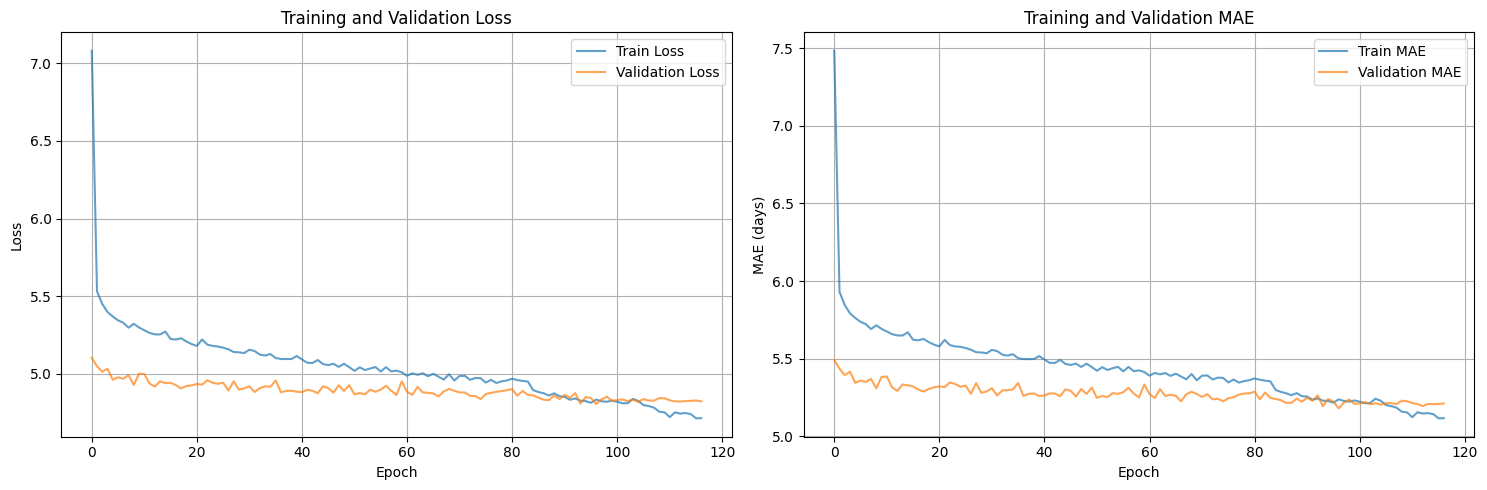

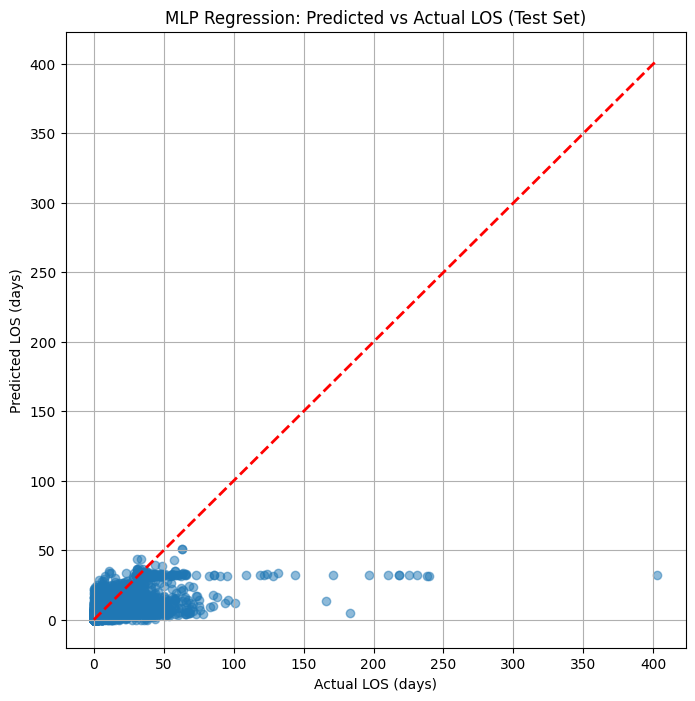


MLP REGRESSION COMPLETE!

TRAINING MLP CLASSIFICATION MODELS

Training Classification Model for K=7 days
Class distribution - Class 0: 23101, Class 1: 13821
Class weights: [0.7991428942470022, 1.3357210042688663]
Training MLP Classification Model (K=7)...
Epoch 10/150 - Train: Loss=0.4106, Acc=0.7735 | Val: Loss=0.4142, Acc=0.7776 | LR=0.001000
Epoch 20/150 - Train: Loss=0.4005, Acc=0.7787 | Val: Loss=0.4194, Acc=0.7579 | LR=0.000500
Epoch 30/150 - Train: Loss=0.3840, Acc=0.7847 | Val: Loss=0.4191, Acc=0.7749 | LR=0.000250
Early stopping at epoch 31 (best val loss: 0.4138, best val acc: 0.7782)

Evaluating MLP Classification Model (K=7)...

Classification Results for K=7 days:
Train - Acc: 0.5159, F1: 0.5222, ROC-AUC: 0.5041
Val   - Acc: 0.7782, F1: 0.7812, ROC-AUC: 0.8811
Test  - Acc: 0.7718, F1: 0.7749, ROC-AUC: 0.8776
Test  - Brier Score: 0.1422

Training Classification Model for K=14 days
Class distribution - Class 0: 27459, Class 1: 9463
Class weights: [0.6723114461560873, 1.9508

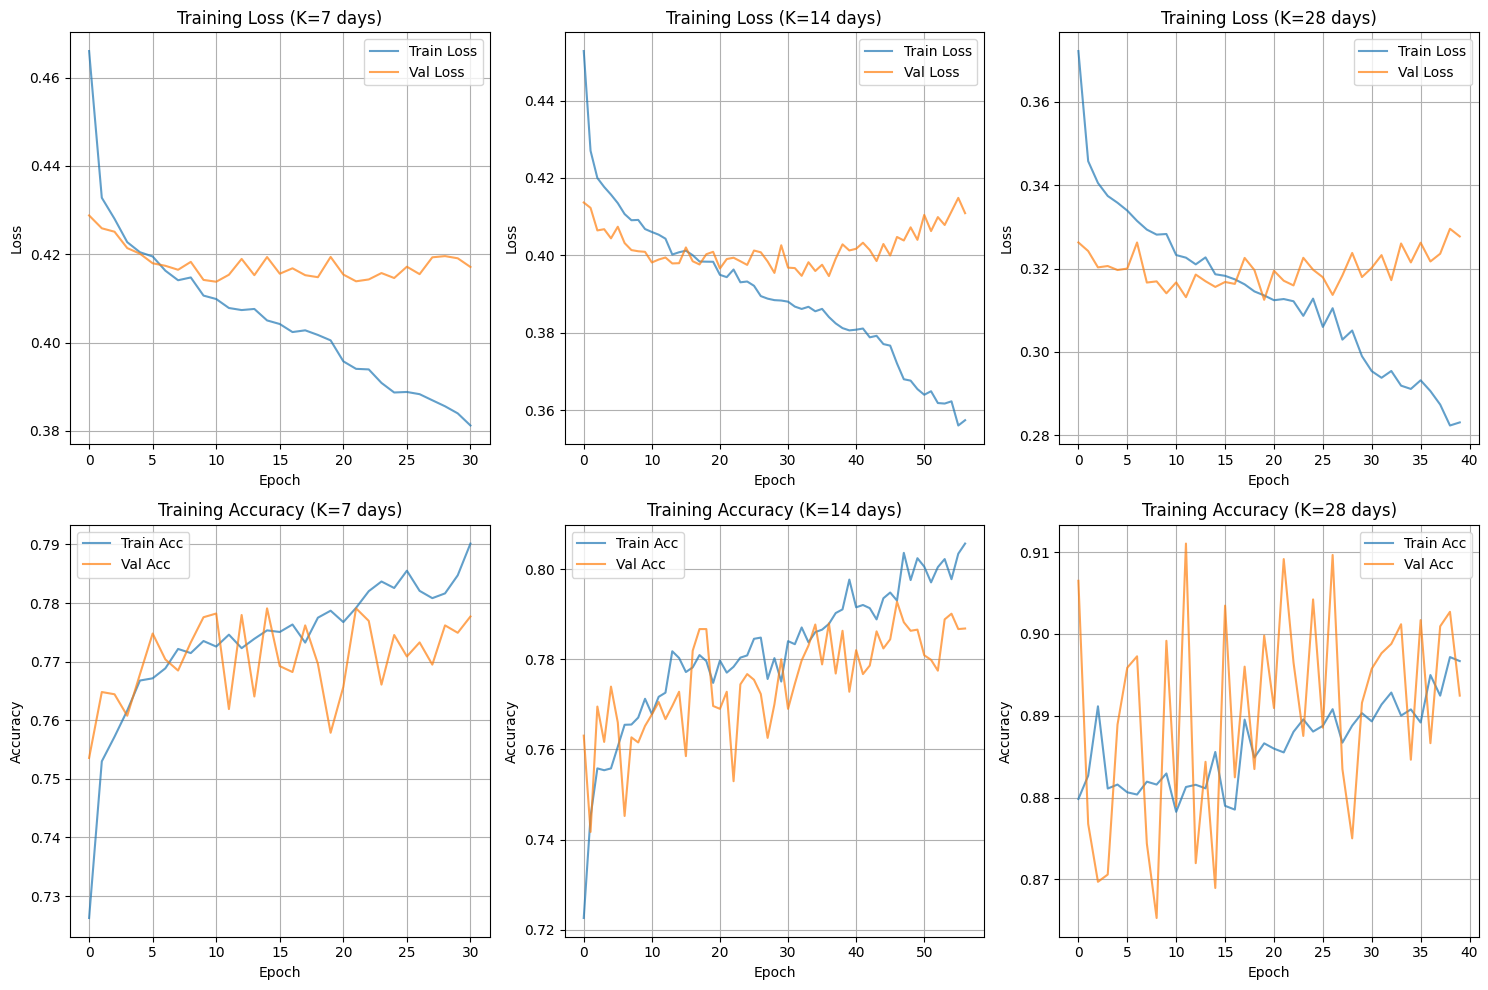

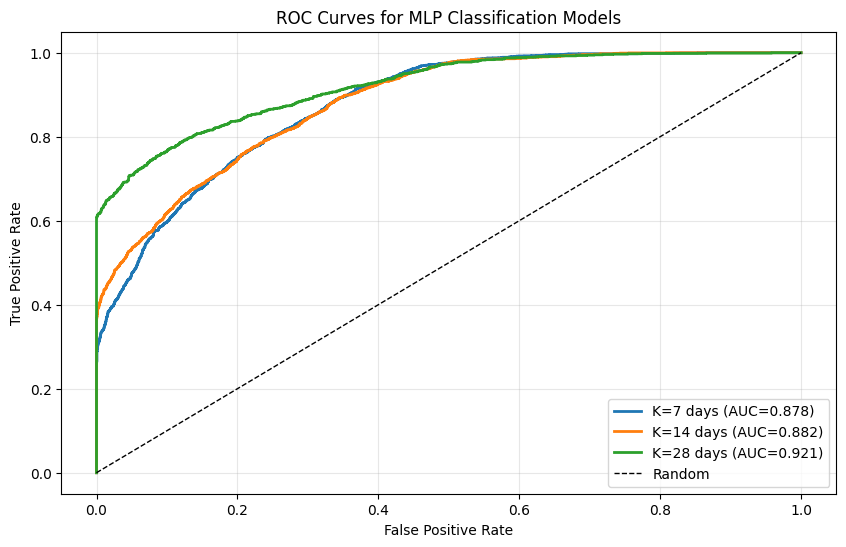

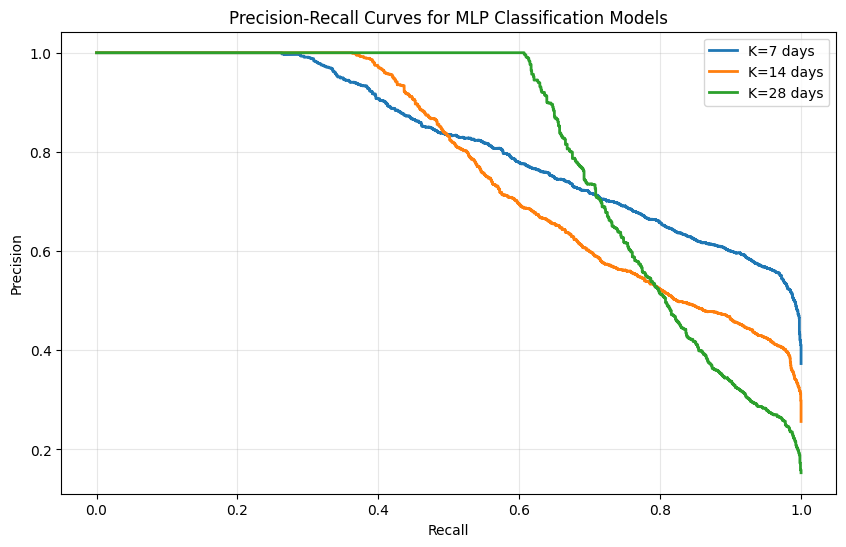

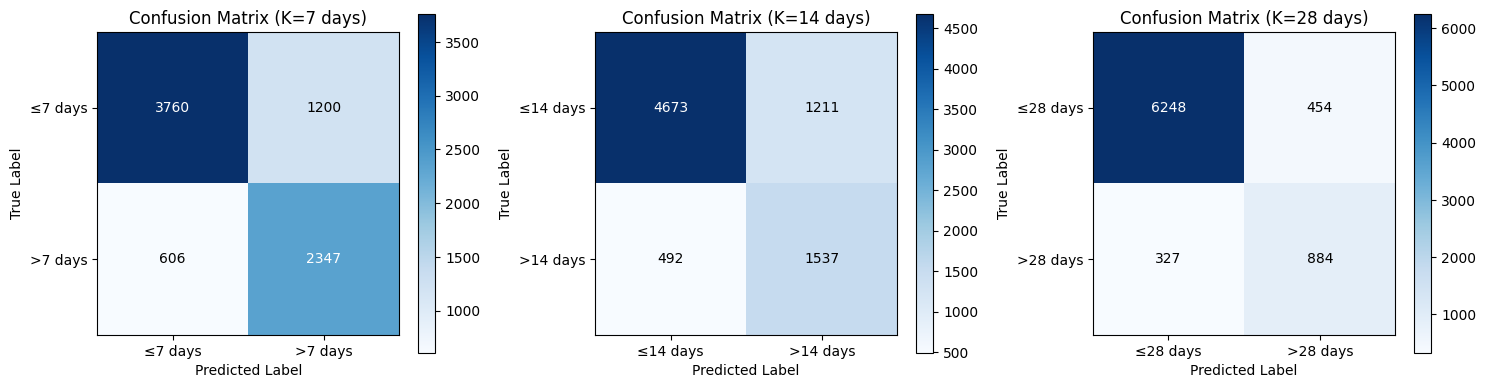


CLASSIFICATION RESULTS SUMMARY
K (days)   Test Accuracy   Test F1      Test ROC-AUC    Brier Score 
------------------------------------------------------------
7          0.7718          0.7749       0.8776          0.14218553689031377
14         0.7848          0.7940       0.8819          0.138036831092689
28         0.9013          0.9033       0.9206          0.09108252930225857

ALL MODELS TRAINING COMPLETE!


In [10]:
if __name__ == '__main__':
    device = get_device()
    print(f"Using device: {device}")

    # Load and preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test, meta = load_dallas_data_for_mlp_regression(device=device)

    # Create datasets and dataloaders
    train_dataset = TabularDataset(X_train, y_train)
    val_dataset = TabularDataset(X_val, y_val)
    test_dataset = TabularDataset(X_test)

    # Optimized batch size - larger for better gradient estimates
    BATCH_SIZE = 128
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if device.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

    # Initialize and train improved MLP model
    input_dim = meta['input_dim']
    print(f"\nModel input dimension: {input_dim}")
    
    # Use improved architecture with deeper network
    mlp_model = ImprovedMLP(
        input_dim=input_dim, 
        hidden_sizes=[256, 128, 64],  # Deeper network
        dropout=0.4,  # Slightly higher dropout for regularization
        num_outputs=1,
        use_residual=False  # Can enable for very deep networks
    )
    
    print(f"Model architecture: {mlp_model}")
    print(f"Total parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")
    
    print("\nTraining Improved MLP Regression Model...")
    mlp_model, train_losses, val_losses, train_maes, val_maes = train_mlp_regression(
        mlp_model, train_loader, val_loader, 
        num_epochs=150,  # More epochs
        lr=0.001,  # Initial learning rate
        patience=20,  # More patience
        device=device,
        use_huber_loss=True,  # Use Huber loss for robustness
        weight_decay=1e-4  # L2 regularization
    )

    # Evaluate model
    print("\nEvaluating MLP Regression Model...")
    _, train_metrics = evaluate_mlp_regression(mlp_model, train_loader, device, y_train)
    _, val_metrics = evaluate_mlp_regression(mlp_model, val_loader, device, y_val)
    test_predictions, test_metrics = evaluate_mlp_regression(mlp_model, test_loader, device, y_test)

    print("\nMLP Regression Results:")
    print(f"Train - MAE: {train_metrics['mae']:.2f}, RMSE: {train_metrics['rmse']:.2f}, R²: {train_metrics['r2']:.4f}")
    print(f"Val   - MAE: {val_metrics['mae']:.2f}, RMSE: {val_metrics['rmse']:.2f}, R²: {val_metrics['r2']:.4f}")
    print(f"Test  - MAE: {test_metrics['mae']:.2f}, RMSE: {test_metrics['rmse']:.2f}, R²: {test_metrics['r2']:.4f}")

    # Plotting training and validation loss
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    axes[0].plot(train_losses, label='Train Loss', alpha=0.7)
    axes[0].plot(val_losses, label='Validation Loss', alpha=0.7)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # MAE curves (if available)
    if len(train_maes) > 0:
        axes[1].plot(train_maes, label='Train MAE', alpha=0.7)
        axes[1].plot(val_maes, label='Validation MAE', alpha=0.7)
        axes[1].set_title('Training and Validation MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE (days)')
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('plots/mlp_loss_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Plotting Predicted vs Actual
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, test_predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual LOS (days)')
    plt.ylabel('Predicted LOS (days)')
    plt.title('MLP Regression: Predicted vs Actual LOS (Test Set)')
    plt.grid(True)
    plt.savefig('plots/mlp_predicted_vs_actual.png')
    plt.show()
    
    print("\n" + "="*60)
    print("MLP REGRESSION COMPLETE!")
    print("="*60)
    
    # ========== CLASSIFICATION MODELS ==========
    print("\n" + "="*60)
    print("TRAINING MLP CLASSIFICATION MODELS")
    print("="*60)
    
    K_VALUES = [7, 14, 28]  # Days threshold for classification
    classification_results = {}
    
    for k in K_VALUES:
        print(f"\n{'='*60}")
        print(f"Training Classification Model for K={k} days")
        print(f"{'='*60}")
        
        # Create binary classification labels: 1 if StayLength > k, else 0
        y_train_cls = (y_train > k).astype(int)
        y_val_cls = (y_val > k).astype(int)
        y_test_cls = (y_test > k).astype(int)
        
        # Calculate class weights for imbalanced data
        from collections import Counter
        class_counts = Counter(y_train_cls)
        total = sum(class_counts.values())
        class_weights = [total / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]
        print(f"Class distribution - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")
        print(f"Class weights: {class_weights}")
        
        # Create datasets
        train_dataset_cls = TabularDataset(X_train, y_train_cls)
        val_dataset_cls = TabularDataset(X_val, y_val_cls)
        test_dataset_cls = TabularDataset(X_test, y_test_cls)
        
        train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, shuffle=True, 
                                      num_workers=0, pin_memory=True if device.type == 'cuda' else False)
        val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE, shuffle=False, 
                                   num_workers=0, pin_memory=True if device.type == 'cuda' else False)
        test_loader_cls = DataLoader(test_dataset_cls, batch_size=BATCH_SIZE, shuffle=False, 
                                     num_workers=0, pin_memory=True if device.type == 'cuda' else False)
        
        # Initialize classification model (2 outputs for binary classification)
        mlp_cls_model = ImprovedMLP(
            input_dim=input_dim,
            hidden_sizes=[256, 128, 64],
            dropout=0.4,
            num_outputs=2,  # Binary classification
            use_residual=False
        )
        
        print(f"Training MLP Classification Model (K={k})...")
        mlp_cls_model, train_losses_cls, val_losses_cls, train_accs_cls, val_accs_cls = train_mlp_classification(
            mlp_cls_model, train_loader_cls, val_loader_cls,
            num_epochs=150,
            lr=0.001,
            patience=20,
            device=device,
            weight_decay=1e-4,
            class_weights=class_weights
        )
        
        # Evaluate model
        print(f"\nEvaluating MLP Classification Model (K={k})...")
        train_preds_cls, train_probs_cls, train_metrics_cls = evaluate_mlp_classification(
            mlp_cls_model, train_loader_cls, device, y_train_cls
        )
        val_preds_cls, val_probs_cls, val_metrics_cls = evaluate_mlp_classification(
            mlp_cls_model, val_loader_cls, device, y_val_cls
        )
        test_preds_cls, test_probs_cls, test_metrics_cls = evaluate_mlp_classification(
            mlp_cls_model, test_loader_cls, device, y_test_cls
        )
        
        print(f"\nClassification Results for K={k} days:")
        print(f"Train - Acc: {train_metrics_cls['accuracy']:.4f}, F1: {train_metrics_cls['f1']:.4f}, "
              f"ROC-AUC: {train_metrics_cls['roc_auc']:.4f}")
        print(f"Val   - Acc: {val_metrics_cls['accuracy']:.4f}, F1: {val_metrics_cls['f1']:.4f}, "
              f"ROC-AUC: {val_metrics_cls['roc_auc']:.4f}")
        print(f"Test  - Acc: {test_metrics_cls['accuracy']:.4f}, F1: {test_metrics_cls['f1']:.4f}, "
              f"ROC-AUC: {test_metrics_cls['roc_auc']:.4f}")
        if test_metrics_cls['brier_score'] is not None:
            print(f"Test  - Brier Score: {test_metrics_cls['brier_score']:.4f}")
        
        # Save model
        torch.save(mlp_cls_model.state_dict(), f'models/mlp_classifier_K{k}_weights.pt')
        
        # Store results
        classification_results[k] = {
            'train': train_metrics_cls,
            'val': val_metrics_cls,
            'test': test_metrics_cls,
            'test_predictions': test_preds_cls,
            'test_probabilities': test_probs_cls,
            'test_labels': y_test_cls,
            'train_losses': train_losses_cls,
            'val_losses': val_losses_cls,
            'train_accs': train_accs_cls,
            'val_accs': val_accs_cls
        }
    
    # ========== VISUALIZATION ==========
    print("\n" + "="*60)
    print("GENERATING CLASSIFICATION VISUALIZATIONS")
    print("="*60)
    
    # Plot training curves for all K values
    fig, axes = plt.subplots(2, len(K_VALUES), figsize=(5*len(K_VALUES), 10))
    if len(K_VALUES) == 1:
        axes = axes.reshape(2, 1)
    
    for idx, k in enumerate(K_VALUES):
        results = classification_results[k]
        
        # Loss curves
        axes[0, idx].plot(results['train_losses'], label='Train Loss', alpha=0.7)
        axes[0, idx].plot(results['val_losses'], label='Val Loss', alpha=0.7)
        axes[0, idx].set_title(f'Training Loss (K={k} days)')
        axes[0, idx].set_xlabel('Epoch')
        axes[0, idx].set_ylabel('Loss')
        axes[0, idx].legend()
        axes[0, idx].grid(True)
        
        # Accuracy curves
        axes[1, idx].plot(results['train_accs'], label='Train Acc', alpha=0.7)
        axes[1, idx].plot(results['val_accs'], label='Val Acc', alpha=0.7)
        axes[1, idx].set_title(f'Training Accuracy (K={k} days)')
        axes[1, idx].set_xlabel('Epoch')
        axes[1, idx].set_ylabel('Accuracy')
        axes[1, idx].legend()
        axes[1, idx].grid(True)
    
    plt.tight_layout()
    plt.savefig('plots/mlp_classification_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ROC Curves
    plt.figure(figsize=(10, 6))
    for k in K_VALUES:
        results = classification_results[k]
        y_true = results['test_labels']
        y_probs = results['test_probabilities'][:, 1]  # Probability of class 1
        
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc = results['test']['roc_auc']
        plt.plot(fpr, tpr, label=f'K={k} days (AUC={auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for MLP Classification Models')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('plots/mlp_classification_roc_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Precision-Recall Curves
    plt.figure(figsize=(10, 6))
    for k in K_VALUES:
        results = classification_results[k]
        y_true = results['test_labels']
        y_probs = results['test_probabilities'][:, 1]
        
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        plt.plot(recall, precision, label=f'K={k} days', linewidth=2)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for MLP Classification Models')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('plots/mlp_classification_pr_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Confusion Matrices
    fig, axes = plt.subplots(1, len(K_VALUES), figsize=(5*len(K_VALUES), 4))
    if len(K_VALUES) == 1:
        axes = [axes]
    
    for idx, k in enumerate(K_VALUES):
        results = classification_results[k]
        cm = results['test']['confusion_matrix']
        
        im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[idx].figure.colorbar(im, ax=axes[idx])
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[idx].text(j, i, format(cm[i, j], 'd'),
                             ha="center", va="center",
                             color="white" if cm[i, j] > thresh else "black")
        
        axes[idx].set_title(f'Confusion Matrix (K={k} days)')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_xticks([0, 1])
        axes[idx].set_yticks([0, 1])
        axes[idx].set_xticklabels([f'≤{k} days', f'>{k} days'])
        axes[idx].set_yticklabels([f'≤{k} days', f'>{k} days'])
    
    plt.tight_layout()
    plt.savefig('plots/mlp_classification_confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary comparison
    print("\n" + "="*60)
    print("CLASSIFICATION RESULTS SUMMARY")
    print("="*60)
    print(f"{'K (days)':<10} {'Test Accuracy':<15} {'Test F1':<12} {'Test ROC-AUC':<15} {'Brier Score':<12}")
    print("-" * 60)
    for k in K_VALUES:
        results = classification_results[k]
        test_metrics = results['test']
        brier = test_metrics['brier_score'] if test_metrics['brier_score'] is not None else 'N/A'
        print(f"{k:<10} {test_metrics['accuracy']:<15.4f} {test_metrics['f1']:<12.4f} "
              f"{test_metrics['roc_auc']:<15.4f} {str(brier):<12}")
    
    print("\n" + "="*60)
    print("ALL MODELS TRAINING COMPLETE!")
    print("="*60)